In [4]:
cd .

/Users/maxcohen/Documents/Python/NYC Data/NYPD-arrests


In [5]:
ls

2010 Census Tracts/
ACS5yearBK/
NYC Street Centerline (CSCL)/
NYC Street Centerline (CSCL).zip
NYPD-repository/
NYPD_Arrest_Historic_DataDictionary.xlsx
NYPD_Arrests_Data__Historic_.csv


In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import geopandas as gpd
from scipy.stats import gaussian_kde
import seaborn as sns
from shapely.geometry import shape, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import plotly.express as px

POSSIBLE AREAS OF INTEREST

What crimes disproprtionatly affect black people?
- Search for Marijuana in the arrest dataset
    - Are marijuana crimes more likely to result in serious charges for black people?
    
Where do certain arrests happen?
- Where are people arrested for marijuana? Robbery? Sexual assault?

Most common words in arrest charges by race? Gender?

Gender or age differences?

What precincts are the "worst"?

Map the racial arrest gap
The goal here is to create a visualization of where black people are disproportionatly arrested
- Most readily done by finding the census demographics at each arrest lat/lon
    - Then compare the census demo to the arrest demo and determine how far off it is
    - For example: in x census tract, black people make up 30% of the population but are 75% of the arrests

Sources
- NYC Centerline Data 
-- https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b
- NYTimes Mapping Segregation
-- https://www.nytimes.com/interactive/2015/07/08/us/census-race-map.html?mtrref=www.google.com&assetType=PAYWALL
- US Census Population Data
-- https://www.census.gov/quickfacts/fact/table/kingscountybrooklynboroughnewyork,newyorkcitynewyork/PST045219
- Racial Dot Map
-- http://racialdotmap.demographics.coopercenter.org/
- NYPD Precincts Map
-- https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz
- NYPD Arrests Data
-- https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u
- NYC Census Tracts Data
-- https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
- ACS Tables
-- https://data.census.gov/cedsci/
- NHGIS
-- https://data2.nhgis.org/main

Important Resources
- https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/
- https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/
- https://datashader.org/getting_started/Introduction.html
- https://seaborn.pydata.org/generated/seaborn.kdeplot.html
- http://andrewgaidus.com/Dot_Density_County_Maps/
- https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9

### LOAD ALL DATA

In [8]:
#census tract map of Brooklyn
census_tracts = gpd.read_file(
    '2010 Census Tracts/geo_export_7c8515b7-143e-4d01-972b-35868adf5281.shp')
bk_census_tracts = census_tracts[census_tracts['boro_name'] == 'Brooklyn']

In [43]:
#ACS census tract demo data
acs_demo = pd.read_csv('ACS5yearBK/ACS5yearBK_data.csv', skiprows=0).drop(['Unnamed: 0'], axis=1)
#ACS census tract demo data dictionary
acs_data_dict = pd.read_csv('ACS5yearBK/ACS5yearBK_data_dict.csv',skiprows=1)

In [11]:
#street centerline map of nyc
our_streets = gpd.read_file('NYC Street Centerline (CSCL)/geo_export_c00f9a7a-d11b-4436-bc33-9fcb9a060d9d.shp')

In [12]:
#Borough Codes
# 1-Man 2-Bronx 3-Brooklyn 4-Queens 5-Staten Island
#brooklyn streets
bk_base = (our_streets[(our_streets['borocode'] == '3') & #brooklyn=3 
                       (our_streets['rw_type'] != 14)]) #remove ferry routes

In [13]:
#create a baselayer for non-bk centerline map
notbk_base = (our_streets[(our_streets['borocode'] != '3') & #brooklyn=3 
                       (our_streets['rw_type'] != 14)]) #remove ferry routes

In [17]:
#read column dictionary
xls = pd.ExcelFile('NYPD_Arrest_Historic_DataDictionary.xlsx')
arrest_col_info = pd.read_excel(xls, 'Column Info', header=1)
#delete filler columns with NaN vals
col_info = arrest_col_info.drop(columns=list(arrest_col_info.columns[2:]))

In [19]:
#read arrests file
df = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

### CLEAN ARRESTS DATA

In [20]:
#limit arrest file to Brooklyn
df = df[ (df['Latitude'] < 40.8) & (df['ARREST_BORO'] == 'K') ]

In [21]:
#change arrest dates to datetime
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])

In [23]:
#number of unique values in all of the arrest description columns'
for i in df.columns[2:8]:
    uni_vals = len(df[i].value_counts().sort_values(ascending=False))
    print(str(i) + ' | ' + str(uni_vals))

PD_CD | 316
PD_DESC | 388
KY_CD | 73
OFNS_DESC | 82
LAW_CODE | 1870
LAW_CAT_CD | 4


In [24]:
#limit jurisdiction codes to 0->3
df['JURISDICTION_CODE'] = df['JURISDICTION_CODE'].apply(lambda x: 3 if x>2 else x)

In [25]:
#Limit age groups to 6 main categories
#First, create the list of the 6 main category labels
age_groups = df['AGE_GROUP'].value_counts().sort_values(ascending=False)[:5].index.to_list()

In [26]:
#Write eveything that is not in one of these categories as NaN
df['AGE_GROUP'] = df['AGE_GROUP'].apply(lambda x: np.nan if x not in age_groups else x)

In [27]:
#turn all of those NaN age_group values into real age groups based on the proportion of age groups in the data
#1. make a dictionary of the age groups and their percentages in the data
age_group_dict = dict(df['AGE_GROUP'].value_counts(normalize=True))
age_group_keys = list(age_group_dict.keys())
age_group_values = list(age_group_dict.values())
#2. randomly fillna with the proportion of each value
df['AGE_GROUP'] = df['AGE_GROUP'].fillna(
    pd.Series(np.random.choice(age_group_keys, p=age_group_values, size=len(df))))

In [28]:
#Group "black hispanic" and "white hispanic" into "hispanic"
#This could be flawed
#*** Before combining, "White Hispanic" was 26% and "Black Hispanic" was 8% ***
df['PERP_RACE'] = df['PERP_RACE'].apply(lambda x: 'HISPANIC' if x.endswith('HISPANIC') else x)

Split dates into the following:
    - Year
    - Month #
    - Day # of month
    - Weekday name (optional)
    - Day of year (optional)

In [29]:
df['ARREST_YEAR'] = df['ARREST_DATE'].apply(lambda x: x.year)
df['ARREST_MONTH'] = df['ARREST_DATE'].apply(lambda x: x.month)
df['ARREST_DAY'] = df['ARREST_DATE'].apply(lambda x: x.day)

In [30]:
#most common arresting precincts
df['ARREST_PRECINCT'].value_counts().sort_values(ascending=False)

75     171855
73     138429
79      91083
67      88629
83      79377
77      77582
70      69708
71      65865
60      63197
81      62318
84      60479
90      52706
72      51415
61      42255
69      39900
88      36229
62      35155
68      32542
63      31540
76      29129
78      26467
66      24892
94      21906
104         1
106         1
Name: ARREST_PRECINCT, dtype: int64

### DEOMGRAPHICS AND ACS DATA CLEANING

This is an early attempt to normalize data for the underlying demographics

Black people are 33.9% of the BK population, but account for 61.9% of the arrests

In [31]:
df['PERP_RACE'].value_counts(normalize=True)

BLACK                             0.618931
HISPANIC                          0.228247
WHITE                             0.119901
ASIAN / PACIFIC ISLANDER          0.024745
UNKNOWN                           0.006313
AMERICAN INDIAN/ALASKAN NATIVE    0.001692
OTHER                             0.000172
Name: PERP_RACE, dtype: float64

The goal here is to create a visualization of where black people are disproportionatly arrested
- Most readily done by finding the census demographics at each arrest lat/lon
    - Then compare the census demo to the arrest demo and determine how far off it is
    - For example: at x,x black people make up 50% of the population but are 75% of the arrests
   
Handling "Hispanic" census data
- https://www.census.gov/topics/population/hispanic-origin/about/comparing-race-and-hispanic-origin.html
- With the ACS data, we are looking for black people which should all be covered in the "race" categories

- Data steps
    1. ~~Create ACS column that corresponds to census tract names
    2. ~~Collect all the relevant demographics columns in ACS dataframe
    3. ~~Merge the census tract data with the demographic data (or vice verse)
    4. ~~Once those are merged, we have the following:
        - Demo data for each cesnsus tract in Brooklyn
        - Shapefile data for each census tract in BK
    5. ~~Associate each arrest location with a census tract based on the lat/lon data
        - Something like a lambda function that looks at each lat/lon and puts it into a specific census tract
    6. ~~Now we can group by each lat/lon and compare arrest demos to the baseline residency demos

In [45]:
#remove margin of error columns
acs_demo = acs_demo[acs_demo.columns.drop(list(acs_demo.filter(regex='Margin of Error')))]

In [46]:
#create ctlabel column with just the "number" name of census tract
#now this will match the bk_census_tract column
acs_demo['ctlabel'] = acs_demo['Geographic Area Name'].apply(lambda x: x.split('Census Tract ')[1].split(', Kings County')[0])

In [47]:
#Clean up column names
#Attempt to only take "percent estimate" and the final thing, but that doesn't always work
#list(acs_demo.columns)[3][::-1].split('!!')[0][::-1] + '_' + list(acs_demo.columns)[3][::-1].split('!!')[-1][::-1]

In [48]:
#acs_demo.to_csv('ACS5yearBK/ACS5yearBK_data.csv')

In [50]:
#columns that account for all black people (of one race or multiple) in a given census tract
black_pop_columns = ['Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American',
                     'Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American']

In [51]:
#add census tract label to the list so that we can create an abbreviated dataframe
black_pop_columns.insert(0,'ctlabel')

In [52]:
#filter dataframe to only include black population columns
ct_black_pop = acs_demo[black_pop_columns]

In [53]:
#census tract lengths are different, find out which one
#after looking, census tract 9901 from the ACS data has no population, so I will ignore it
pd.Index(ct_black_pop.ctlabel).difference(pd.Index(bk_census_tracts.ctlabel)).values

array(['9901'], dtype=object)

In [54]:
#merge the black pop data onto the bk_census_tracts (shortened to just geometry and census tract name)
ct_black_pop = bk_census_tracts[['ctlabel','geometry']].merge(ct_black_pop, on='ctlabel')

In [55]:
#rename columns
ct_black_pop.rename(columns={'Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American':'total_pop',
                            'Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American':'perc_pop'},
                   inplace=True)

5. Associate each arrest location with a census tract based on the lat/lon data
        - Something like a lambda function that looks at each lat/lon and puts it into a specific census tract
        
If lat/lon is in a polygon, return that polygon in a new column 
then df.merge(ct_black_pop, on='geometry')

In [56]:
#combine lat/lon into one column
df['lonlat'] = list(zip(df['Longitude'], df['Latitude']))

In [57]:
#convert lat/lon into "points"
df['point'] = df['lonlat'].apply(lambda x: Point(x))

In [58]:
#copy the geometry column because we will need a copy when we join the dataframes
ct_black_pop['ctpoly'] = ct_black_pop['geometry']

In [59]:
#turn df into a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'],df['Latitude']))

In [60]:
#sjoin arrest df with black pop df on the geometry column (left=point, right=polygon)
#sjoin determines if the point is intersecting any part of the polygon
#THIS IS SO SIIIIICK
#and is so faaaaast
%time
gdf = gpd.sjoin(gdf, ct_black_pop, how='left', op='intersects')

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 12.9 µs


/Users/maxcohen/opt/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [61]:
#remove NAs
gdf.dropna(inplace=True)

In [62]:
#Function creates a dataframe that is grouped by a geo tag and then returns a new dataframe 
    #of racial disparity in arrests at that geo tag
def geo_combine_arrest_pop(cols):
    geo_race = gdf.groupby(cols).size()\
    .groupby(level=[0])\
    .apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index()\
    .rename(columns={0:'perc_arrest'})
    geo_race_black = geo_race[geo_race['PERP_RACE'] == 'BLACK']
    geo_combo_arrest_pop = geo_race_black.merge(ct_black_pop[['ctlabel','perc_pop','total_pop','geometry']], 
                                                on='ctlabel')
    geo_combo_arrest_pop['perc_pop'] = geo_combo_arrest_pop['perc_pop'].replace('-','0.0').astype('float')
    geo_combo_arrest_pop['diff'] = geo_combo_arrest_pop['perc_arrest'] - geo_combo_arrest_pop['perc_pop']
    geo_combo_arrest_pop = gpd.GeoDataFrame(geo_combo_arrest_pop, geometry=geo_combo_arrest_pop['geometry'])
    return geo_combo_arrest_pop

In [63]:
ct_combo_arrest_pop = geo_combine_arrest_pop(['ctlabel','PERP_RACE'])

In [64]:
lonlat_combo_arrest_pop = geo_combine_arrest_pop(['Longitude','Latitude','ctlabel','PERP_RACE'])

### GRAPHING ARRESTS OVER TIME

In [149]:
df['dayofyear'] = df['ARREST_DATE'].apply(lambda x: x.timetuple().tm_yday)

2          365
5          365
10         365
11         365
12         365
          ... 
5012944      1
5012945      1
5012947      1
5012948      1
5012953      1
Name: ARREST_DATE, Length: 1392660, dtype: int64

In [86]:
arrestsXdate = df['dayofyear'].value_counts().reset_index().rename(columns={'index':'date',
                                                                              'ARREST_DATE':'count'})

In [120]:
arrestsXdate = arrestsXdate.sort_values(by='date')

In [273]:
d7_rol_arr = arrestsXdate_index.rolling(window=7, center=True).mean()

In [274]:
d365_rol_arr = arrestsXdate_index.rolling(window=365, center=True).mean()

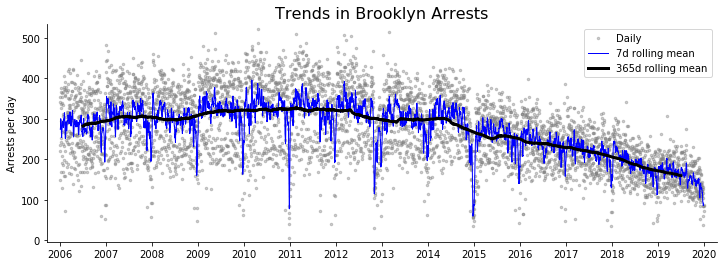

In [332]:
#number of arrests by day
fig,ax = plt.subplots(figsize=(12,4))

ax.plot(arrestsXdate_index['count'], marker='.', markersize=5, 
        alpha=.4, linestyle='None', color='grey', label='Daily')

ax.plot(d7_rol_arr['count'], color='blue', label='7d rolling mean', linewidth=1)

ax.plot(d365_rol_arr['count'], color='black', label='365d rolling mean', linewidth=3)

ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel("Arrests per day")
ax.set_title('Trends in Brooklyn Arrests',fontsize=16)
plt.margins(.02)
#plt.savefig('NYPD-repository/figs/trends_bk_arrests.png', dpi=500, bbox_inches='tight')
plt.show()

In [101]:
dayofyear = df['dayofyear'].value_counts().reset_index().rename(columns={'index':'dayofyear','dayofyear':'count'})

In [115]:
dayofyear = dayofyear.sort_values(by='dayofyear')

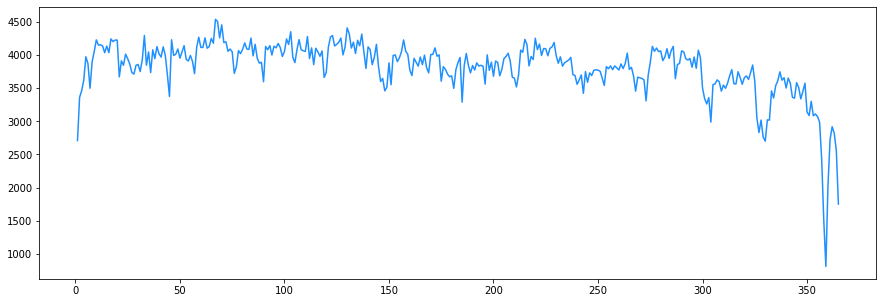

In [333]:
#arrest by day number of year
fig,ax = plt.subplots(figsize=(15,5))

ax.plot(dayofyear['dayofyear'][:-1], dayofyear['count'][:-1], color='dodgerblue')

plt.show()

### ARRESTS BY CHARGES

In [358]:
df.groupby(['PD_DESC','PERP_RACE']).size()\
    .groupby(level=[0])\
    .apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index()\
    .rename(columns={0:'perc_arrest'})

PD_DESC                       PERP_RACE  \
0                   A.B.C.,FALSE PROOF OF AGE  AMERICAN INDIAN/ALASKAN NATIVE   
1                   A.B.C.,FALSE PROOF OF AGE        ASIAN / PACIFIC ISLANDER   
2                   A.B.C.,FALSE PROOF OF AGE                           BLACK   
3                   A.B.C.,FALSE PROOF OF AGE                        HISPANIC   
4                   A.B.C.,FALSE PROOF OF AGE                         UNKNOWN   
...                                       ...                             ...   
1714                   WEAPONS,PROHIBITED USE                           BLACK   
1715                   WEAPONS,PROHIBITED USE                        HISPANIC   
1716                   WEAPONS,PROHIBITED USE                           WHITE   
1717  WEAPONS,PROHIBITED USE IMITATION PISTOL                           BLACK   
1718                      WOUNDS,REPORTING OF                        HISPANIC   

      perc_arrest  
0        1.428571  
1        2.142857  
2       41.428571  
3       36.428571  
4        2.142857  
...           ...  
1714    53.846154  
1715    38.461538  
1716     7.692308  
1717   100.000000  
1718   100.000000  

[1719 rows x 3 columns]

In [410]:
mj = df[~df['PD_DESC'].isnull()]

In [417]:
mj_only = mj[(mj['PD_DESC'].str.contains('MARIJUANA'))]

In [421]:
mj_latlon = mj_only.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

In [422]:
mj_latlon

Longitude   Latitude  count
0     -74.040795  40.624206      3
1     -74.040738  40.626198      1
2     -74.040716  40.625729      8
3     -74.040663  40.626698      2
4     -74.040475  40.620797      7
...          ...        ...    ...
16460 -73.857862  40.666867      5
16461 -73.857790  40.668484      1
16462 -73.857594  40.667690      1
16463 -73.857361  40.666973      2
16464 -73.857268  40.670264      4

[16465 rows x 3 columns]

In [348]:
df.groupby(['OFNS_DESC','PERP_RACE']).size().sort_values(ascending=False).head(40)

OFNS_DESC                                    PERP_RACE
DANGEROUS DRUGS                              BLACK        204017
ASSAULT 3 & RELATED OFFENSES                 BLACK         88352
DANGEROUS DRUGS                              HISPANIC      75883
OTHER STATE LAWS                             BLACK         54132
OTHER OFFENSES RELATED TO THEFT              BLACK         52645
FELONY ASSAULT                               BLACK         40682
MISCELLANEOUS PENAL LAW                      BLACK         39081
DANGEROUS DRUGS                              WHITE         38786
DANGEROUS WEAPONS                            BLACK         38235
ROBBERY                                      BLACK         35366
OTHER TRAFFIC INFRACTION                     BLACK         34581
ASSAULT 3 & RELATED OFFENSES                 HISPANIC      34542
CRIMINAL TRESPASS                            BLACK         27034
VEHICLE AND TRAFFIC LAWS                     BLACK         26644
PETIT LARCENY                      

### MAPS

#an attempt at creating a baselayer function

def bk_base():
    #brooklyn streets baselaye
    fig,ax = plt.subplots(figsize=(15,15))

    bk_base = (our_streets[(our_streets['borocode'] == '3') & #brooklyn=3 
                           (our_streets['rw_type'] != 14) & #remove ferry routes
                           (our_streets['l_zip'] != '11693')]) #remove a sliver of a street in Jamaica Bay

    bk_base.plot(ax=ax, color='grey', alpha=.7)

    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_xticklines()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    return ax

bk_base()

In [67]:
#a function to remove axes spines, ticks, and labels
def set_map_axes(ax=None):
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_xticklines()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax.set_xlim(-74.050,-73.850)
    ax.set_ylim(40.565,40.745)
    
    return ax

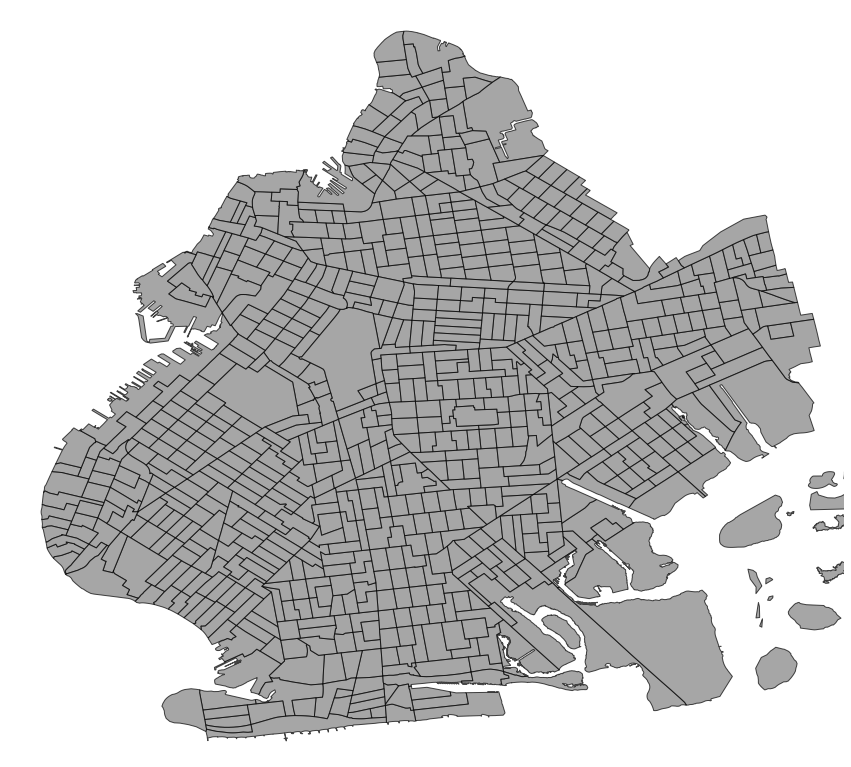

In [69]:
#brooklyn census tracts
fig,ax = plt.subplots(figsize=(15,15))

bk_census_tracts.plot(ax=ax, color='grey', alpha=.7, edgecolor='black')

set_map_axes(ax=ax)

plt.show()

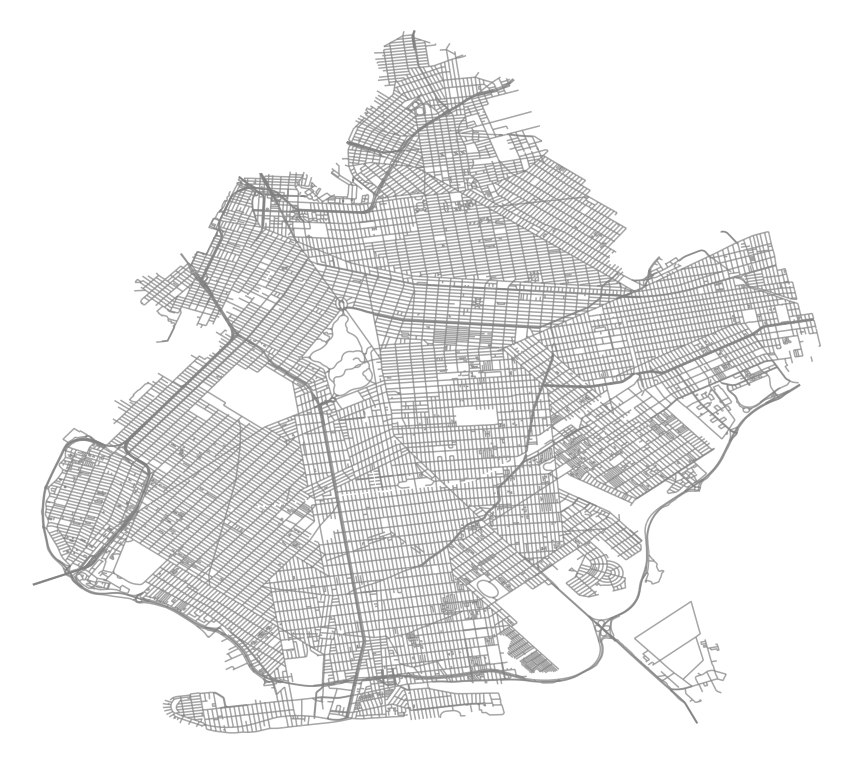

In [70]:
#brooklyn streets baselayer
fig,ax = plt.subplots(figsize=(15,15))
           
bk_base.plot(ax=ax, color='grey', alpha=.7)

set_map_axes(ax=ax)

plt.show()

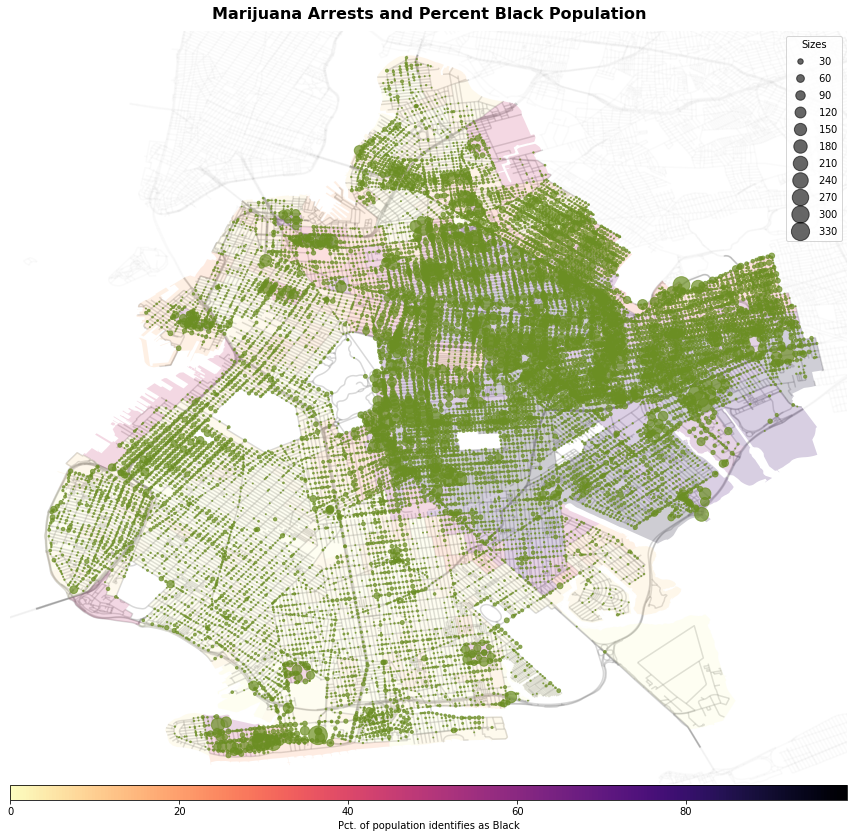

In [432]:
#Marijuana arrests overlayed on top of census tract map of black population percentage
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

bk_base.plot(ax=ax, color='grey', alpha=.3, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

#remove census tracts with 0 population
no_nonpop = ct_combo_arrest_pop[ct_combo_arrest_pop['all_pop'] != 0]

no_nonpop.plot(ax=ax, column=no_nonpop['perc_pop'], cmap='magma_r', alpha=.2, zorder=3, 
               legend=True, cax=cax,
               legend_kwds={'label':'Pct. of population identifies as Black',
                            'orientation':'horizontal'})
scatter = ax.scatter(mj_latlon['Longitude'], mj_latlon['Latitude'], 
           alpha=.7, color='olivedrab', marker='o', s=mj_latlon['count'], zorder=4, label='')

set_map_axes(ax=ax)

handles, labels = scatter.legend_elements(prop='sizes', alpha=.6)
legend2 = ax.legend(handles, labels, loc='upper right', title='Sizes')

ax.set_title('Marijuana Arrests and Percent Black Population', pad=12, 
             fontdict={'fontsize':16,'fontweight':'bold'})
#plt.savefig('NYPD-repository/figs/arrest_disparity_by_census_tract.png', dpi=500, bbox_inches='tight')
plt.show()

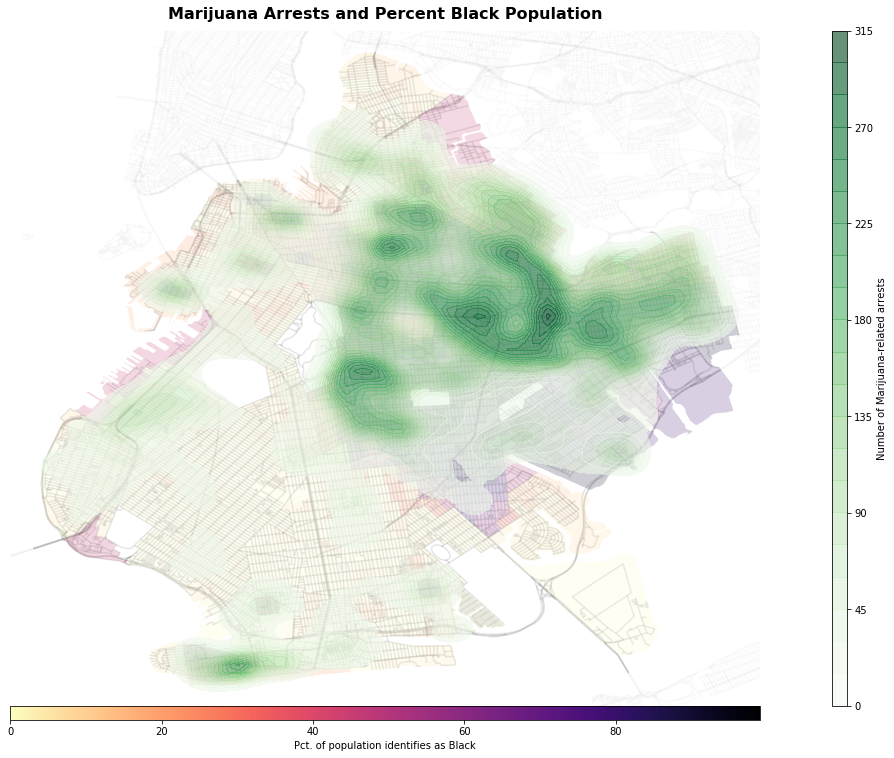

In [446]:
#Marijuana arrests overlayed on top of census tract map of black population percentage WITH KDE
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)
kax = divider.append_axes('right', size='2%', pad=1)

bk_base.plot(ax=ax, color='grey', alpha=.2, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

#remove census tracts with 0 population
no_nonpop = ct_combo_arrest_pop[ct_combo_arrest_pop['all_pop'] != 0]
no_nonpop.plot(ax=ax, column=no_nonpop['perc_pop'], cmap='magma_r', alpha=.2, zorder=3, 
               legend=True, cax=cax,
               legend_kwds={'label':'Pct. of population identifies as Black',
                            'orientation':'horizontal'})

sample = 10000
mj_only_samp = mj_only
x = mj_only_samp['Longitude']
y = mj_only_samp['Latitude']

sns.kdeplot(x, y, ax=ax, shade=True, alpha=.6, n_levels=20, cmap='Greens', 
            shade_lowest=False, zorder=4,
            cbar_ax=kax, cbar=True, 
            cbar_kws={'label':"Number of Marijuana-related arrests"})

set_map_axes(ax=ax)

ax.set_title('Marijuana Arrests and Percent Black Population', pad=12, 
             fontdict={'fontsize':16,'fontweight':'bold'})
plt.savefig('NYPD-repository/figs/marijuana_arrests_pct_black_pop.png', dpi=500, bbox_inches='tight')
plt.show()

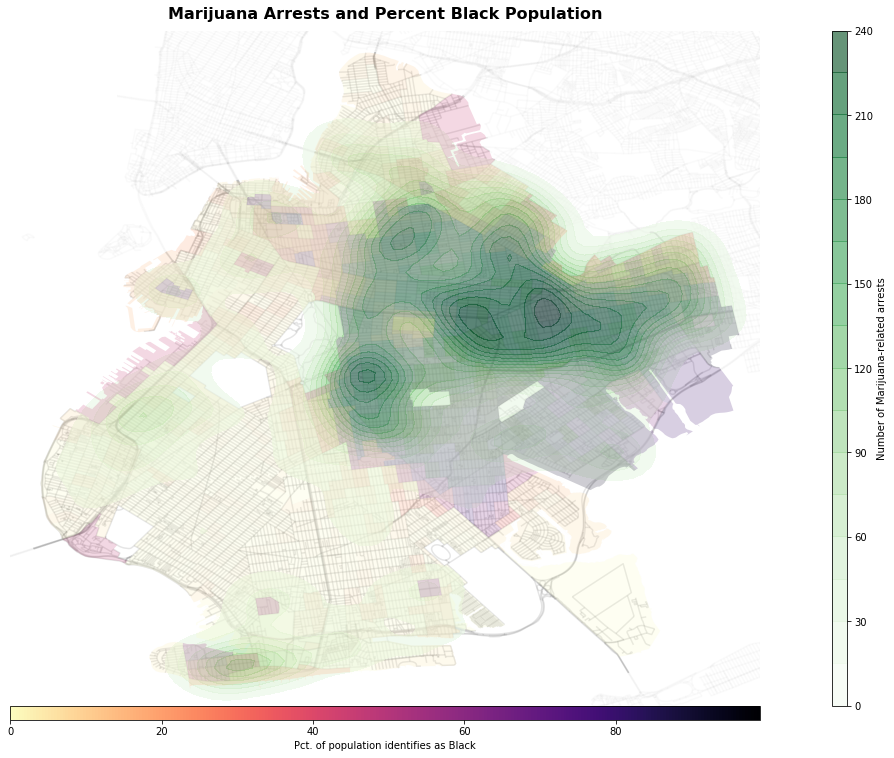

In [449]:
#Marijuana arrests overlayed on top of census tract map of black population percentage WITH KDE
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)
kax = divider.append_axes('right', size='2%', pad=1)

bk_base.plot(ax=ax, color='grey', alpha=.2, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

#remove census tracts with 0 population
no_nonpop = ct_combo_arrest_pop[ct_combo_arrest_pop['all_pop'] != 0]
no_nonpop.plot(ax=ax, column=no_nonpop['perc_pop'], cmap='magma_r', alpha=.2, zorder=4, 
               legend=True, cax=cax,
               legend_kwds={'label':'Pct. of population identifies as Black',
                            'orientation':'horizontal'})

sample = 10000
mj_only_samp = mj_only.sample(sample)
x = mj_only_samp['Longitude']
y = mj_only_samp['Latitude']

sns.kdeplot(x, y, ax=ax, shade=True, alpha=.6, n_levels=20, cmap='Greens', 
            shade_lowest=False, zorder=3,
            cbar_ax=kax, cbar=True, 
            cbar_kws={'label':"Number of Marijuana-related arrests"})

set_map_axes(ax=ax)

ax.set_title('Marijuana Arrests and Percent Black Population', pad=12, 
             fontdict={'fontsize':16,'fontweight':'bold'})
#plt.savefig('NYPD-repository/figs/marijuana_arrests_pct_black_pop.png', dpi=500, bbox_inches='tight')
plt.show()

In [385]:
ct_combo_arrest_pop = ct_combo_arrest_pop.merge(acs_demo[['ctlabel',
                                                          'Estimate!!RACE!!Total population']], 
                                                on='ctlabel').rename(columns={'Estimate!!RACE!!Total population':
                                                                      'all_pop'})

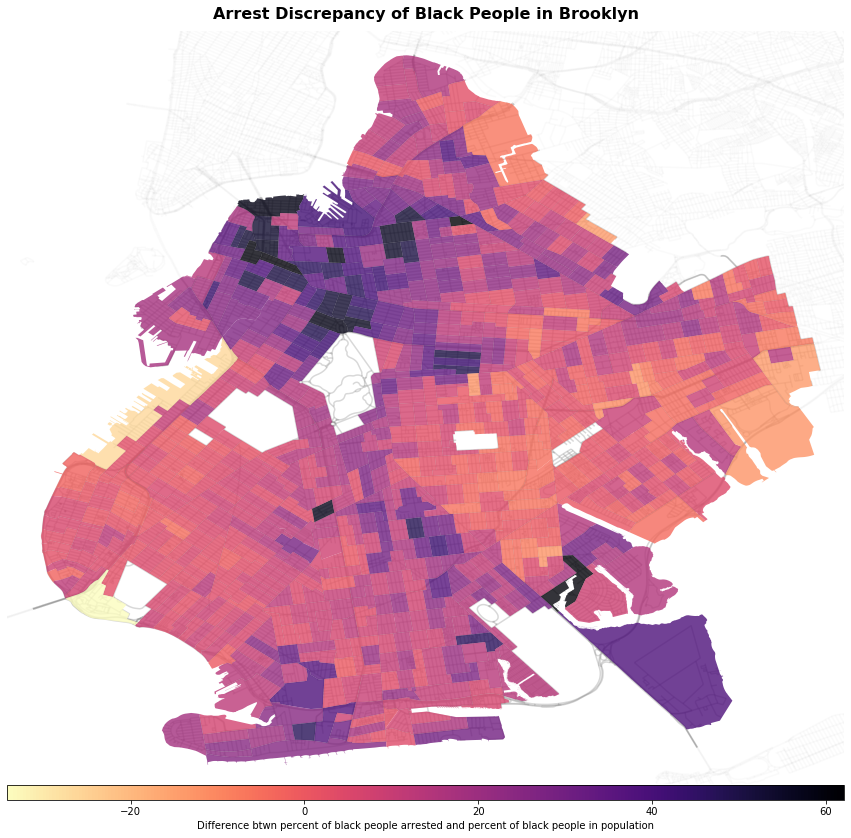

In [400]:
#brooklyn census tracts by percent arrested
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

bk_base.plot(ax=ax, color='grey', alpha=.3, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)


#remove census tracts with 0 population
no_nonpop = ct_combo_arrest_pop[ct_combo_arrest_pop['all_pop'] != 0]

no_nonpop.plot(ax=ax, column=no_nonpop['diff'], cmap='magma_r', alpha=.8, zorder=3, 
               legend=True, cax=cax,
               legend_kwds={'label':'Difference btwn percent of black people arrested and percent of black people in population',
                            'orientation':'horizontal'})

set_map_axes(ax=ax)
ax.set_title('Arrest Discrepancy of Black People in Brooklyn', pad=12, 
             fontdict={'fontsize':16,'fontweight':'bold'})
plt.savefig('NYPD-repository/figs/arrest_disparity_by_census_tract.png', 
            dpi=500, bbox_inches='tight')
plt.show()

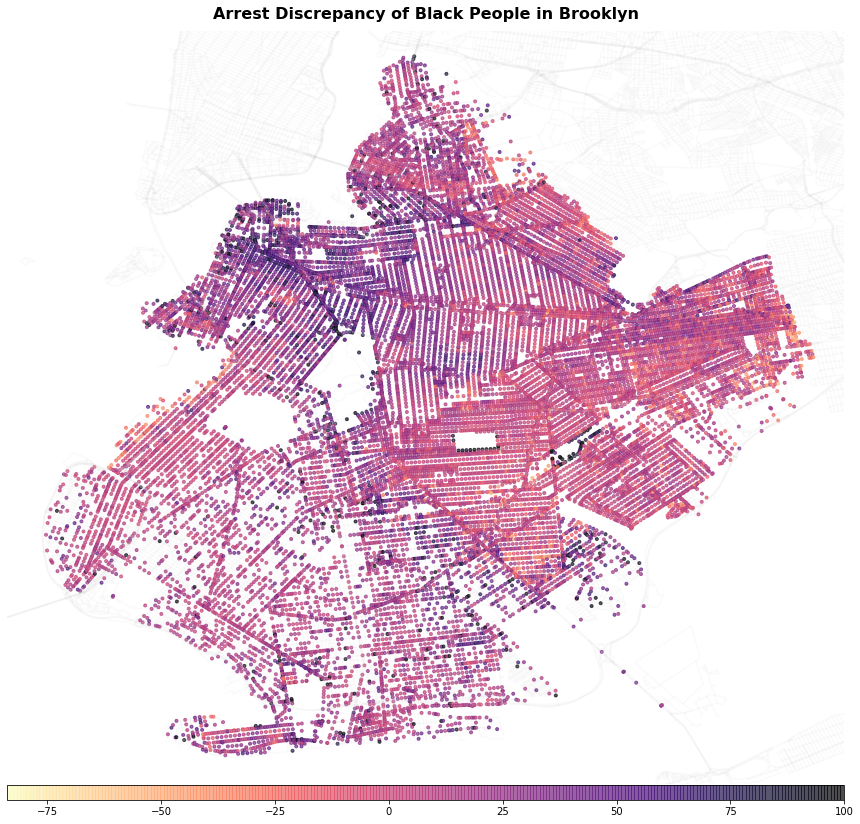

In [402]:
#brooklyn lat/lon
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

bk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

pop0_filt = lonlat_combo_arrest_pop[lonlat_combo_arrest_pop['total_pop'] > 0]
diff = pop0_filt['diff']
im = ax.scatter(x=lonlat_combo_arrest_pop['Longitude'], y=lonlat_combo_arrest_pop['Latitude'], 
                marker='.', alpha=.7, c=lonlat_combo_arrest_pop['diff'], cmap='magma_r')

set_map_axes(ax=ax)

plt.colorbar(im, cax, orientation='horizontal')

ax.set_title('Arrest Discrepancy of Black People in Brooklyn', pad=12, 
             fontdict={'fontsize':16,'fontweight':'bold'})
plt.savefig('NYPD-repository/figs/arrest_disparity_by_latlon.png', dpi=500, bbox_inches='tight')
plt.show()

### Map some different arrest data in Brooklyn

In [ ]:
#White felony arrests in Brooklyn by gender 
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'WHITE') & 
              (df['LAW_CAT_CD'] == 'F') & 
              (df['PERP_SEX'] == 'M')]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'WHITE') & 
               (df['LAW_CAT_CD'] == 'F') & 
               (df['PERP_SEX'] == 'M')]['Latitude'], 
            marker='.', alpha=.2, color='blue')

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'WHITE') & 
              (df['LAW_CAT_CD'] == 'F') & 
              (df['PERP_SEX'] == 'F')]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'WHITE') & 
               (df['LAW_CAT_CD'] == 'F') & 
               (df['PERP_SEX'] == 'F')]['Latitude'], 
            marker='.', alpha=.2, color='red')

declutter_axes(ax=ax)

plt.show()

In [ ]:
#get a set of columns that does not include lon/lat
cols = df.columns.to_list()
cols.remove('Latitude')
cols.remove('Longitude')
cols

In [ ]:
#find the percent of each each race present at each lon/lat
race_size = df.groupby(['Latitude','Longitude','PERP_RACE']).size()
race_pct = race_size.groupby(level=[0,1]).apply(lambda x: 100 * x / float(x.sum()))

In [ ]:
race_pct

In [ ]:
#rename column 0 as 'race_pct'
df_race_pct = race_pct.reset_index().rename(columns={0:'race_pct'})

In [ ]:
#return most common arrest race for each lon/lat
#1. groupby lon/lat and reutrn column of race_pct organized by max percent
#2. reset the index
#3. merge back with the original race pct dataframe to get the lat/lon values 
df_max_race = df_race_pct.groupby(['Latitude','Longitude'])['race_pct'].max().reset_index().merge(df_race_pct, on=['Latitude','Longitude','race_pct'])


In [ ]:
#add boro column to max_race df
df_max_race_boro = df_max_race.merge(df[['Latitude','Longitude','ARREST_BORO']], on=['Latitude','Longitude'])

### Better Maps

Now we have a dataframe organized by each unqiue set of (long, lat, race) with a value for how common each race is at that unique longitude and latitude
With this unique information, we want to plot the following on a map:
- Color for the dominant race
- That color changes depending on how dominant it is at that lon/lat
- Does the color change depending on the make up of the races?
    - Black -> White -> Hispanic is diffent then White -> Hispanic -> Black?
    - or could it be compared to the racial breakdown of that area?
        - Black people are mis-represented in this arrest data by this percent...
        
I think final answer for now is to group by the majority race and then create a bubble that shows the size of arrests at that lat/lon location
- scatter by lat/lon and color by race category

In [ ]:
df_max_race_boro['PERP_RACE'].value_counts(normalize=True)

In [ ]:
#map the MOST arrested race at each lat/lon
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

marker = '.'
alpha = .7
s = 10

colors = {'WHITE':'green', 'ASIAN / PACIFIC ISLANDER':'orange', 'HISPANIC':'red', 'BLACK':'blue', 
          'UNKNOWN':'yellow', 'AMERICAN INDIAN/ALASKAN NATIVE':'purple', 'OTHER':'black'}

ax.scatter(df_max_race_boro[(df_max_race_boro['ARREST_BORO'] == 'K') &
                            (df_max_race_boro['Latitude'] < 40.8)]['Longitude'], 
           df_max_race_boro[(df_max_race_boro['ARREST_BORO'] == 'K') &
                            (df_max_race_boro['Latitude'] < 40.8)]['Latitude'], 
           c=df_max_race_boro[(df_max_race_boro['ARREST_BORO'] =='K') &
                            (df_max_race_boro['Latitude'] < 40.8)]['PERP_RACE'].apply(lambda x: colors[x]), 
           alpha=alpha, marker=marker, s=s)

declutter_axes(ax=ax)


plt.show()

In [ ]:
#map the MOST arrested race at each lat/lon and marker size changes depending on total number of arrests

In [ ]:
num_arrests = df[(df['ARREST_BORO'] == 'K') & (df['Latitude'] < 40.8)].groupby(['Latitude','Longitude']).size().reset_index().rename(columns={0:'tot_arrests'})

In [ ]:
brooklyn = df[(df['ARREST_BORO'] == 'K') & (df['Latitude'] < 40.8)]

In [ ]:
#map the MOST arrested race at each lat/lon
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

marker = '.'
alpha = .7
s = 10

colors = {'WHITE':'green', 'ASIAN / PACIFIC ISLANDER':'orange', 'HISPANIC':'red', 'BLACK':'blue', 
          'UNKNOWN':'yellow', 'AMERICAN INDIAN/ALASKAN NATIVE':'purple', 'OTHER':'black'}

ax.scatter(brooklyn['Longitude'], 
           brooklyn['Latitude'], 
           c=brooklyn['PERP_RACE'].apply(lambda x: colors[x]), 
           alpha=alpha, marker=marker, s=s)

declutter_axes(ax=ax)

plt.show()

In [ ]:
brooklyn.head()

### KDE PLOT (takes 30 min to run)

fig, ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

#sample = 100
bk_sample = brooklyn[brooklyn['PERP_RACE'] == 'BLACK']#.sample(sample)
x = bk_sample['Longitude']
y = bk_sample['Latitude']
sns.kdeplot(x, y, ax=ax, shade=True, alpha=1, n_levels=20, cmap='magma_r', shade_lowest=False, zorder=2,
            cbar_ax=cax, cbar=True, 
            cbar_kws={'label':"Number of Black People Arrested in Brooklyn, NY ('06-'19)",
                      'orientation':'horizontal'})

bk_base.plot(ax=ax, color='grey', alpha=.2, zorder=3)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

ax.set_xlim(-74.050,-73.850)
ax.set_ylim(40.565,40.745)

declutter_axes(ax=ax)

#plt.savefig('figs/black_arrest_density.png', dpi=500, bbox_inches='tight')
plt.show()